In [17]:
import os
import sys
from pathlib import Path

from datetime import datetime
from tqdm import tqdm

import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp



import matplotlib.pyplot as plt

from dataloader.load_regression_data_from_arbitrary_gp import RegressionDataGeneratorArbitraryGP
from dataloader.load_mnist import load_mnist
from dataloader.load_celeb import load_celeb

from neural_process_model_hybrid import NeuralProcessHybrid
from neural_process_model_latent import NeuralProcessLatent
#from model import ConditionalNeuralProcess as NeuralProcess
from utility import PlotCallback

tfk = tf.keras
tfd = tfp.distributions

In [18]:
tf.config.set_visible_devices([], 'GPU') # DONT use the GPU, not needed
args = argparse.Namespace(epochs=15, batch=1024, task='regression', num_context=10,
                          uniform_sampling=True, model='LNP')

In [19]:
# Training parameters
BATCH_SIZE = args.batch
EPOCHS = args.epochs



TRAINING_ITERATIONS = int(100) # 1e5
TEST_ITERATIONS = int(TRAINING_ITERATIONS/5)
if args.task == 'mnist':
    train_ds, test_ds, TRAINING_ITERATIONS, TEST_ITERATIONS = load_mnist(batch_size=BATCH_SIZE, num_context_points=args.num_context, uniform_sampling=args.uniform_sampling)
    
    # Model architecture
    z_output_sizes = [500, 500, 500, 500]
    enc_output_sizes = [500, 500, 500, 1000]
    dec_output_sizes = [500, 500, 500, 2]


elif args.task == 'regression':
    data_generator = RegressionDataGeneratorArbitraryGP(
        iterations=TRAINING_ITERATIONS,
        n_iterations_test=TEST_ITERATIONS,
        batch_size=BATCH_SIZE,
        min_num_context=3,
        max_num_context=40,
        min_num_target=2,
        max_num_target=40,
        min_x_val_uniform=-2,
        max_x_val_uniform=2,
        kernel_length_scale=0.4,
        
    )
    train_ds, test_ds = data_generator.load_regression_data()

    # Model architecture
    z_output_sizes = [500, 500, 500, 500]
    enc_output_sizes = [500, 500, 500, 1000]
    dec_output_sizes = [500, 500, 500, 2]

    

elif args.task == 'celeb':
    train_ds, test_ds, TRAINING_ITERATIONS, TEST_ITERATIONS = load_celeb(batch_size=BATCH_SIZE, num_context_points=args.num_context,
                                   uniform_sampling=args.uniform_sampling)

    # Model architecture
    z_output_sizes = [500, 500, 500, 500]
    enc_output_sizes = [500, 500, 500, 1000]
    dec_output_sizes = [500, 500, 500, 6]

In [28]:
def load_np_model(model_path: str) -> tf.keras.Model:
    assert Path(model_path).parent.is_dir()
    
    z_output_sizes = [500, 500, 500, 500]
    enc_output_sizes = [500, 500, 500, 1000]
    dec_output_sizes = [500, 500, 500, 6]
    
    model = NeuralProcessLatent(z_output_sizes=z_output_sizes,
                                enc_output_sizes=enc_output_sizes,
                                dec_output_sizes=dec_output_sizes)
    
    model.load_weights(model_path)
    
    return model

In [29]:
model_path = "checkpoints/LNP_model_regression_context_10_uniform_sampling_True/cp-0121.ckpt"
model = load_np_model(model_path)

2023-03-11 21:21:23.892515: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


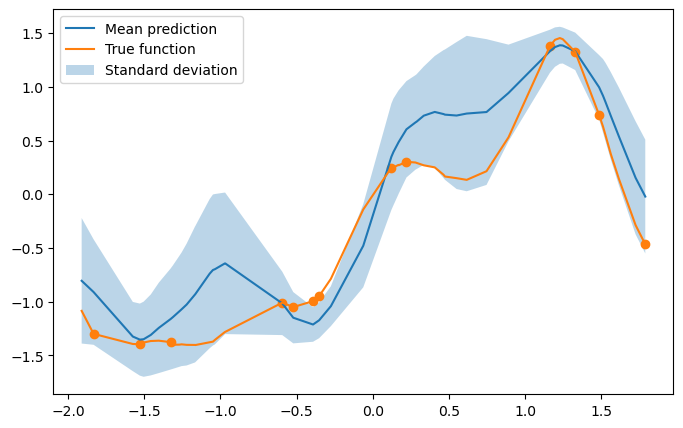

In [6]:
def plot_mean_with_std(x: np.ndarray,
                       mean: np.ndarray,
                       std: np.ndarray,
                       y_true=None,
                       ax=None,
                       alpha: float=0.3) -> plt.Axes:
    """Plot mean and standard deviation.
    IMPORTANT: x should be sorted and mean and std should be sorted in the same order as x."""
    
    if ax is None:
        ax = plt.gca()
    
    # Plot mean:
    ax.plot(x, mean, label="Mean prediction")  # type: ignore
    
    # Plot target if given:
    if y_true is not None:
        ax.plot(x, y_true, label="True function")
    
    # Plot standard deviation:
    ax.fill_between(x,  # type: ignore
                    mean - std,  # type: ignore
                    mean + std,  # type: ignore
                    alpha=alpha,
                    label="Standard deviation")
    
    ax.legend()
    
    return ax  # type: ignore
def plot_regression(target_x, target_y, context_x, context_y, pred_y):
    fig, ax = plt.subplots(figsize=(8, 5))
    
    
    x_val = tf.squeeze(target_x[0, :, :])
    pred_y = tf.squeeze(pred_y[0, :, :])
    y_true = tf.squeeze(target_y[0, :, :])
    
    idx_x_sorted = tf.argsort(x_val)
    
    x_val = tf.gather(x_val, idx_x_sorted)
    mean = tf.gather(pred_y[:, 0], idx_x_sorted)
    std = tf.gather(pred_y[:, 1], idx_x_sorted)
    y_true = tf.gather(y_true, idx_x_sorted)
    
    plot_mean_with_std(x=x_val, mean=mean, std=std, y_true=y_true, ax=ax)
    ax.scatter(context_x[0, :, :], context_y[0, :, :])  # type: ignore
    
    return fig


# model_path = f'.data/{args.model}_model_{args.task}_context_{args.num_context}_uniform_sampling_{args.uniform_sampling}/' \
#                     + "cp-.ckpt"


            
tf.random.set_seed(3)
test_iter = iter(test_ds)
x = next(test_iter)

(context_x, context_y, target_x), target_y = x
pred_y = model(x[0])
fig = plot_regression(target_x, target_y, context_x, context_y, pred_y)
#fig.suptitle(f'loss {logs["loss"]:.5f}')